# **Data analysis on cancellation notebook**

## Objectives

* Answer business requirement: discover hotel room booking cancellation pattern and identify variables that are correlated to cancellation the most

## Inputs

* outputs/datasets/collections/hotel_bookings.csv

## Outputs

* Generate code to answer the above business requirement and use it to build the Streamlit app


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5-hotel-hocuspocus/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5-hotel-hocuspocus'

---

# Load data

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


---

# Data exploration

Get familiar with the dataset, check variable type and distribution, missing levels, and what these variables mean in a business context.

In [19]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation study

Drop rows with missing values before transforming using OneHotEncoder because it will raise ValueError otherwise.

In [ ]:
# Drop rows with missing values
df_dropped = df.dropna()

The following columns are directly related to non-cancellation and cancellation status of bookings: `reservation_status`, `reservation_status_date`, `assigned_room_type` (set in the booking management system when guests check-in at the hotel).

Therefore these columns will be dropped to avoid data leakage.

In [ ]:
# Drop features directly related to cancellation
df_dropped = df_dropped.drop(
    ['reservation_status', 'reservation_status_date', 'assigned_room_type'],
    axis=1
)

In [ ]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(variables=df_dropped.columns[df_dropped.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df_dropped)
print(df_ohe.shape)
df_ohe.head(3)

Use `.corr()` for spearman and pearson methods and investigate the top 10 correlations.
- This command returns a pandas series and the first item is the correlation between `is_cancelled` and `is_cancelled`, which happens to be 1, so exclude that with [1:].
- Sort values considering the absolute value by setting `key=abs`.

In [ ]:
corr_spearman = df_ohe.corr(method='spearman')['is_canceled'].sort_values(
    key=abs, ascending=False
)[1:].head(10)
corr_spearman

Do the same for pearson.

In [ ]:
corr_pearson = df_ohe.corr(method='pearson')['is_canceled'].sort_values(
    key=abs, ascending=False
)[1:].head(10)
corr_pearson

For both methods, very weak or weak levels of correlation between `is_cancelled` and a given variable are observed.

Strong correlation level is ideal, but in this case, the top five correlation levels will be considered for data analysis, despite low levels of correlation, to gain insights into cancellation patterns. Although correlation does not mean causation, it is hoped that a general trend will be gleaned from data analysis.

In [ ]:
top_n = 5
set(
    corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list()
)

Based on the above, the following variables will be studied in relation to cancellations:
- `arrival_date_month`
- `country`
- `distribution_channel`
- `stays_in_weekend_nights`

`arrival_date_week_number` will not be studied as it is quite similar to `arrival_date_month`.

In [5]:
vars_to_study = ['arrival_date_month', 'country', 'distribution_channel', 'stays_in_weekend_nights']
vars_to_study

['arrival_date_month',
 'country',
 'distribution_channel',
 'stays_in_weekend_nights']

# Data analysis on selected variables

In [17]:
df_eda = df.filter(vars_to_study + ['is_canceled'])
df_eda.head(3)

,arrival_date_month,country,distribution_channel,stays_in_weekend_nights,is_canceled
0,July,PRT,Direct,0,0
1,July,PRT,Direct,0,0
2,July,GBR,Direct,0,0


## Arrival date month

The following question will be investigated:
- Which months have the highest number of cancellations?

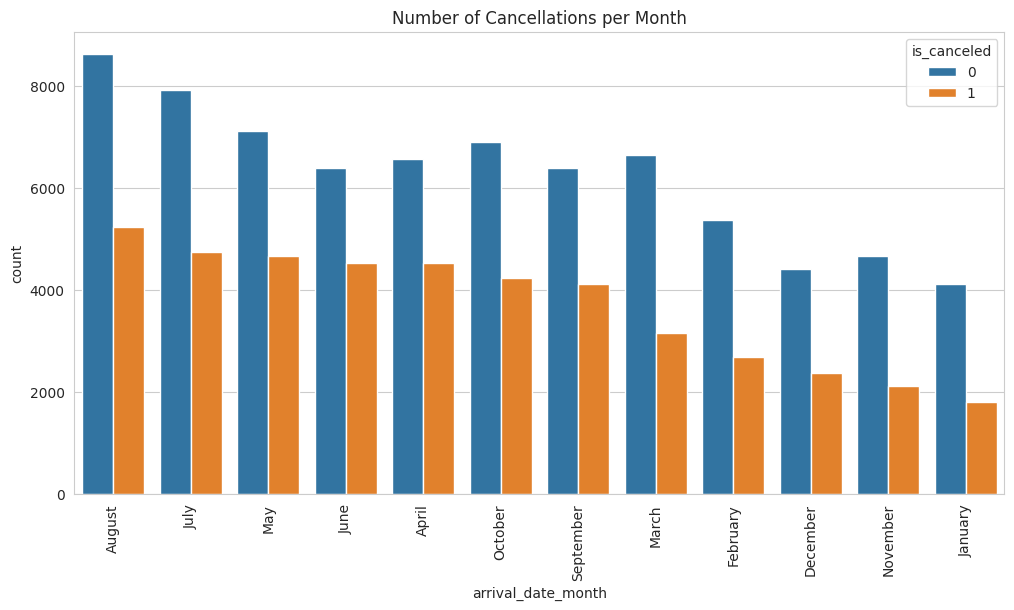

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Calculate total number of cancellations for each month
cancellations = df_eda[df_eda['is_canceled'] == 1].groupby(
    'arrival_date_month'
).size()

# Sort months by number of cancellations in descending order
sorted_months = cancellations.sort_values(ascending=False).index.tolist()

# Countplot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_eda,
    x='arrival_date_month',
    hue='is_canceled',
    order=sorted_months
)
plt.xticks(rotation=90)
plt.title('Number of Cancellations per Month')
plt.xlabel('arrival_date_month')
plt.ylabel('count')
plt.show()

### Conclusion
August, July, and May are the top 3 months with the highest number of cancellations. This is during the summer season.

## Country

The following question will be investigated:
- What are the top 5 countries with the highest number of cancellations?

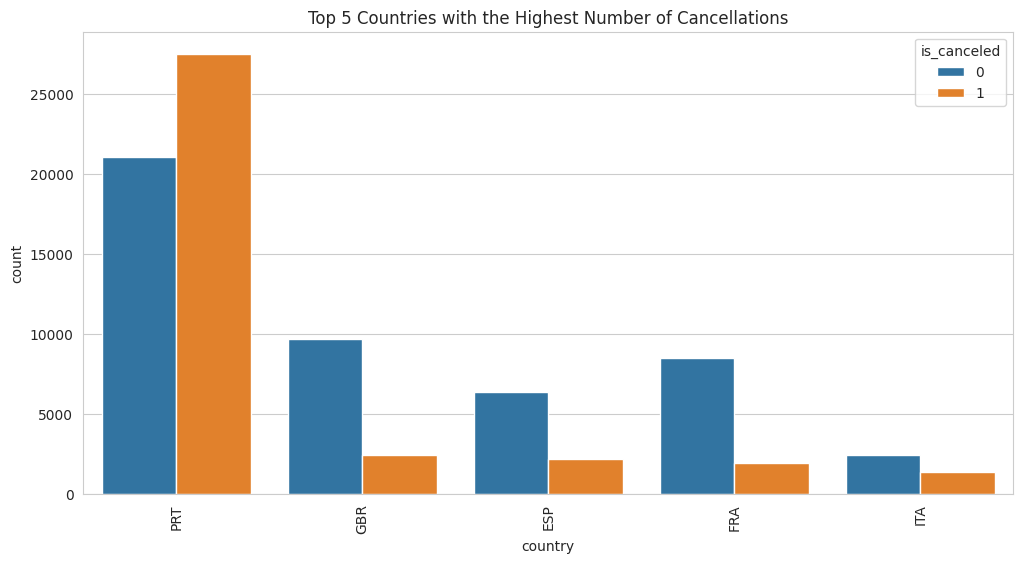

In [21]:
# Calculate total number of cancellations for each country
cancellations_by_country = df_eda[df_eda['is_canceled'] == 1].groupby(
    'country'
).size()

# Get the top 5 countries with the highest number of cancellations
top_5_countries = cancellations_by_country.nlargest(5).index.tolist()

# Filter the top 5 countries
df_top_5 = df_eda[df_eda['country'].isin(top_5_countries)]

# Countplot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_top_5,
    x='country',
    hue='is_canceled',
    order=top_5_countries
)
plt.title('Top 5 Countries with the Highest Number of Cancellations')
plt.xlabel('country')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

### Conclusion
The top 5 countries with the highest number of cancellations are:
- Portugal
- The UK
- Spain
- France
- Italy

## Distribution channels

The following question will be investigated:
- Which booking channels have the highest number of cancellations?

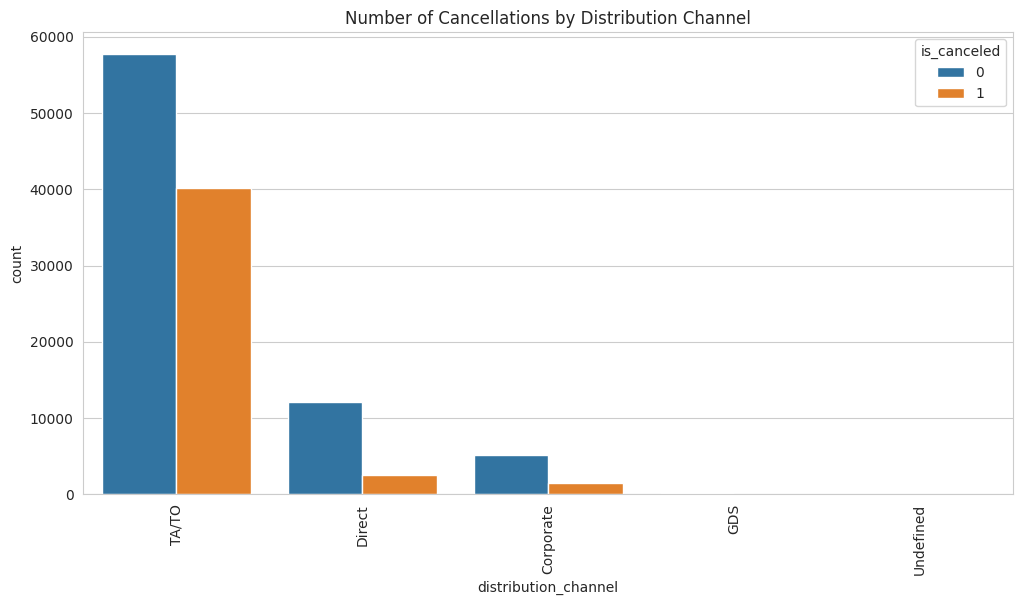

In [22]:
# Calculate total number of cancellations for each distribution channel
cancellations_by_channel = df[df['is_canceled'] == 1].groupby(
    'distribution_channel'
).size()

# Sort distribution channels by number of cancellations in descending order
sorted_channels = cancellations_by_channel.sort_values(
    ascending=False
).index.tolist()

# Countplot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_eda,
    x='distribution_channel',
    hue='is_canceled',
    order=sorted_channels
)
plt.title('Number of Cancellations by Distribution Channel')
plt.xlabel('distribution_channel')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

### Conclusion
There are more cancellations of bookings made through TA's (Travel Agencies) or TO's (Tour Operators) as opposed to bookings made directly with the hotel.

## Weekend nights stay

The following question will be investigated:
- Are bookings with weekend nights stay more likely to be cancelled than those with none?

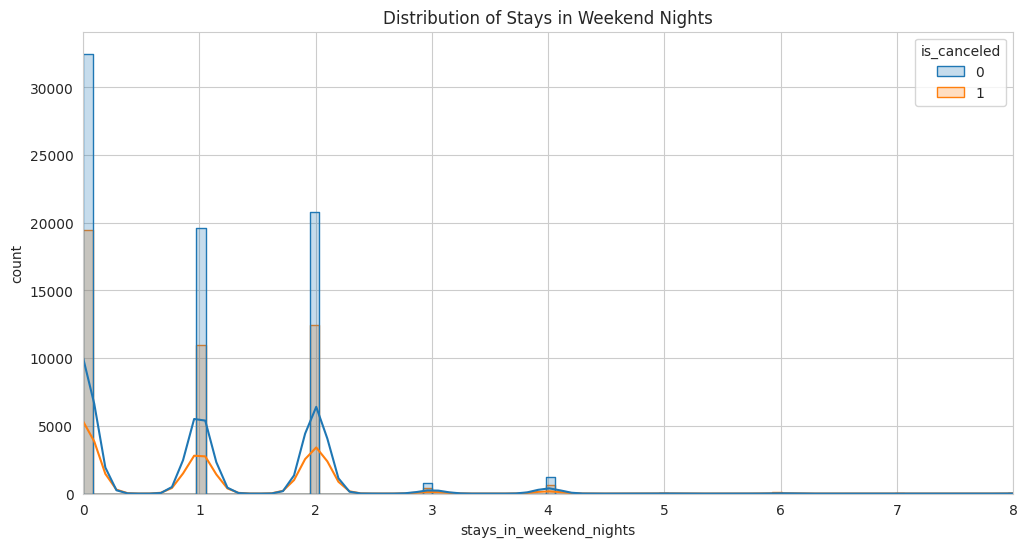

In [24]:
# Histplot
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_eda,
    x='stays_in_weekend_nights',
    hue='is_canceled',
    kde=True,
    element='step'
)
plt.title('Distribution of Stays in Weekend Nights')
plt.xlim(0, 8)
plt.xlabel('stays_in_weekend_nights')
plt.ylabel('count')
plt.show()

### Conclusion
Bookings without any weekend nights stay are cancelled more than bookings with weekend nights stay.

---

# Summary of conclusions

- A correlation study was done on cancellation and it yielded very weak to weak correlation levels with the following top variables:
    - `arrival_date_month`
    - `country`
    - `distribution_channel`
    - `stays_in_weekend_nights`
- Data analysis was carried out on the above variables in relation to cancellations:
    - August, July, and May are the top 3 months with the highest number of cancellations. This is during the summer season.
    - The top 5 countries with the highest number of cancellations are:
        - Portugal
        - The UK
        - Spain
        - France
        - Italy
    - There are more cancellations of bookings made through TA's (Travel Agencies) or TO's (Tour Operators) as opposed to bookings made directly with the hotel.
    - Bookings without any weekend nights stay are cancelled more than bookings with weekend nights stay.

---

# Next steps

Data cleaning will be conducted in preparation for modelling.